##  rna_S2_scVI integration
Read in dataset without lowQC/doublets cluster/ +new remove 'Erythro'

In [1]:
import pandas as pd 
import numpy as np
import scvi
import scanpy as sc

sc.set_figure_params(figsize=(4, 4))

OMP: Info #270: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
dir='/lustre/scratch117/cellgen/team292/rh26/16_explant_sc_2D9_stars_combine/'

In [3]:
#adata = sc.read(dir+'S3_rna_cluster_annotate_1_clean.h5ad')

In [4]:
adata

AnnData object with n_obs × n_vars = 37974 × 35220
    obs: 'sample', 'stage', 'donor_id', 'percent_mito', 'n_counts', 'n_genes', 'batch', 'low_ncounts', 'high_mito', 'low_ncounts_high_mito', 'n_genes_by_counts', 'total_counts', 'total_counts_hum', 'pct_counts_hum', 'total_counts_pf', 'pct_counts_pf', 'stage_0', 'S_score', 'G2M_score', 'phase', 'scrublet_score', 'scrublet_cluster_score', 'zscore', 'bh_pval', 'bonf_pval', 'is_doublet', 'is_doublet_0.05', 'sample_barcode', 'assignment', 'leiden', 'MFidentity', 'cluster'
    var: 'gene_ids', 'feature_types', 'n_cells', 'hum', 'pf', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'MFidentity_colors', 'assignment_colors', 'cluster_colors', 'donor_id_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'phase_colors', 'rank_genes_groups', 'sample_colors', 'stage_0_colors', 'stage_c

## Subset doublet clusters and redo integration

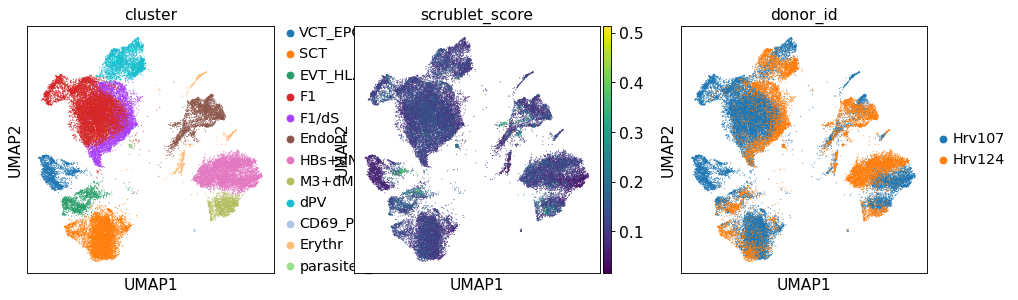

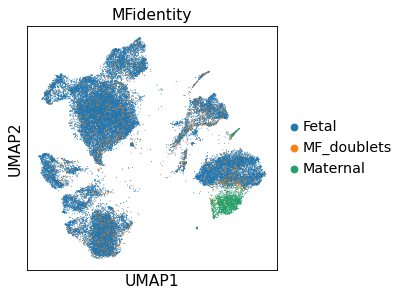

In [5]:
sc.pl.umap(adata, color=['cluster', 'scrublet_score', 'donor_id'])
sc.pl.umap(adata, color=['MFidentity'])

In [6]:
adata.obs['cluster'].values.describe()

,counts,freqs
categories,,
VCT_EPCAM_ITGA6,1753,0.046163
SCT,6018,0.158477
EVT_HLAG,1364,0.035919
F1,12068,0.317796
F1/dS,3294,0.086744
Endo_f,2750,0.072418
HBs+dNKs+Tcells,5831,0.153552
M3+dM1,1391,0.036630
dPV,2833,0.074604


!!! Unlike before (at least I think), now they recommend subsetting to highly variable genes before running scVI
--> the tutorial says anywhere in between 1000 and 10,000 should be fine, so I arbitrarily chose 2000

In [7]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,
    subset=False,
    flavor="seurat_v3",
    batch_key="donor_id"
)

/opt/conda/envs/scvi-singularity/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:144: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[: int(n_top_genes), 'highly_variable'] = True


In [8]:
# subset object for scVI
bdata = adata[:, adata.var['highly_variable']]
bdata.layers["counts"] = bdata.X.copy() # preserve counts

In [12]:
scvi.data.setup_anndata(
    bdata,
    layer="counts",
    batch_key='donor_id',
    categorical_covariate_keys=["sample"])
#     continuous_covariate_keys=["percent_mito"]#

INFO     Using batches from adata.obs["donor_id"]                                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 37974 cells, 2000 vars, 2 batches,
         1 labels, and 0 proteins. Also registered 1 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


In [13]:
model = scvi.model.SCVI(bdata, n_latent= 10)

In [14]:
model

SCVI Model with the following params: 
n_hidden: 128, n_latent: 30, n_layers: 1, dropout_rate: 0.1, dispersion: gene, 
gene_likelihood: zinb, latent_distribution: normal
Training status: Not Trained

To print summary of associated AnnData, use: scvi.data.view_anndata_setup(model.adata)

In [15]:
model.train()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 211/211: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 211/211 [2:18:02<00:00, 39.26s/it, loss=977, v_num=1]


In [16]:
latent = model.get_latent_representation()

In [17]:
adata.obsm["X_scVI"] = latent

## Save latent space

In [18]:
X_scVI=pd.DataFrame(adata.obsm["X_scVI"]).to_csv('/lustre/scratch117/cellgen/team292/rh26/16_explant_sc_2D9_stars_combine/20220428_sc_combi_clean2_obsm_with_scVI_latent_representation_n_10_corrected_by_donor.csv')